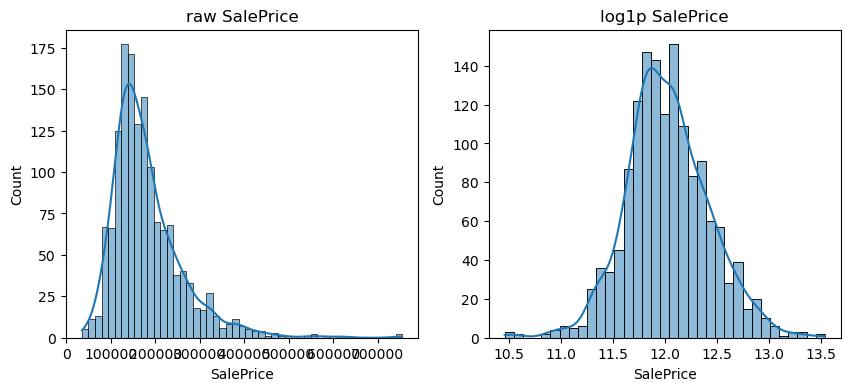

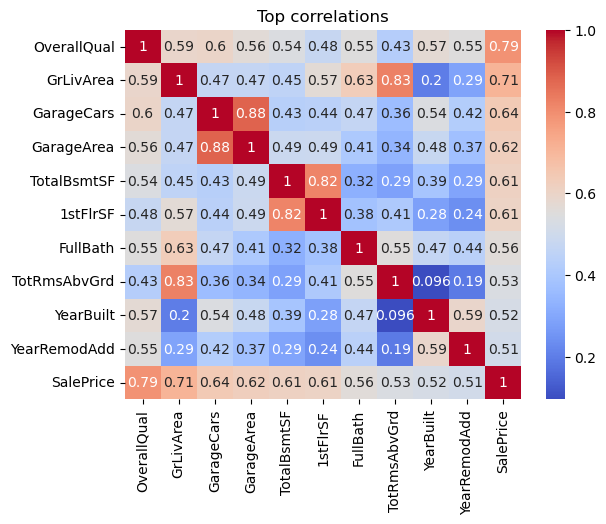


=== OLS (Lasso subset) ===
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.5493      4.596      2.295      0.022       1.532      19.567
MSSubClass               -0.0006      0.000     -1.973      0.049      -0.001   -3.33e-06
LotArea                2.478e-06   4.56e-07      5.433      0.000    1.58e-06    3.37e-06
OverallQual               0.0387      0.004      8.879      0.000       0.030       0.047
OverallCond               0.0423      0.004     10.996      0.000       0.035       0.050
YearBuilt                 0.0017      0.000      5.590      0.000       0.001       0.002
YearRemodAdd              0.0007      0.000      2.766      0.006       0.000       0.001
MasVnrArea             3.463e-05   2.08e-05      1.668      0.095   -6.09e-06    7.53e-05
BsmtFinSF1             3.399e-05   1.32e-05      2.572      0.010    8.0

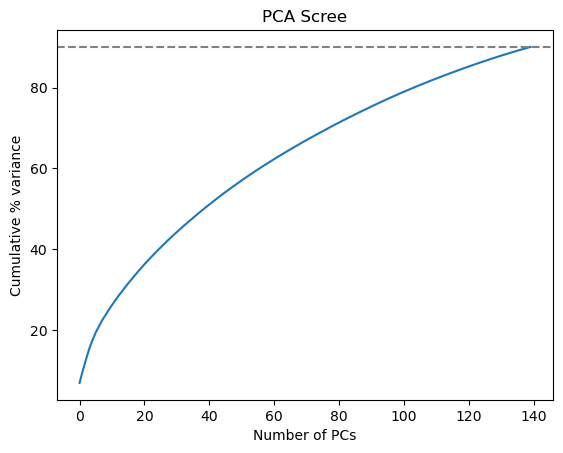


Files saved: model1_Lasso_ols.csv  model2_enet_pca.csv


In [6]:
# ================================================================
# House Prices – House Prices - Advanced Regression Techniques
# Kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques
# DSS8555 Assignment 8
# April 27, 2025
# Min Jeong Lim
#=======================================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools   import durbin_watson, jarque_bera
from sklearn.linear_model          import LassoCV, ElasticNetCV
from sklearn.preprocessing         import StandardScaler
from sklearn.decomposition         import PCA
from sklearn.model_selection       import KFold
import warnings; warnings.filterwarnings('ignore')

# data load
train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
test  = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")
test["SalePrice"] = np.nan
full = pd.concat([train, test], ignore_index=True)

num_cols = full.select_dtypes(["int64","float64"]).columns.drop(["SalePrice","Id"])
cat_cols = full.select_dtypes(["object"]).columns
full[num_cols] = full[num_cols].apply(lambda s: s.fillna(s.median()))
full[cat_cols] = full[cat_cols].fillna("Missing")

# eda
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); sns.histplot(train.SalePrice,kde=True); plt.title("raw SalePrice")
plt.subplot(1,2,2); sns.histplot(np.log1p(train.SalePrice),kde=True); plt.title("log1p SalePrice")
plt.show()

top_corr = (
    train[num_cols.tolist() + ['SalePrice']]   # include target
         .corr()['SalePrice']                  # correlations w/ target
         .abs()
         .sort_values(ascending=False)[1:11]
)
sns.heatmap(train[top_corr.index.tolist()+['SalePrice']].corr(),annot=True,cmap='coolwarm'); plt.title("Top correlations"); plt.show()

# features
full["Remodeled"]          = (full["YearBuilt"] != full["YearRemodAdd"]).astype(int)    # dichotomous
full["GrLivArea2"]         = full["GrLivArea"]**2                                       # polynomial
full["OverallQual_GrLiv"]  = full["OverallQual"] * full["GrLivArea"]                    # interaction
full = pd.get_dummies(full, columns=cat_cols, drop_first=True)

train_clean = full.iloc[:len(train)].copy()
test_clean  = full.iloc[len(train):].copy()

y = np.log1p(train_clean["SalePrice"])
X = train_clean.drop(columns=["SalePrice","Id"])
X_test = test_clean.drop(columns=["SalePrice","Id"])
X       = X.astype(float)
X_test  = X_test.astype(float)

# model 1:  Lasso subset
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=0, n_jobs=-1).fit(X_scaled, y)
sel_mask = np.abs(lasso.coef_) > 1e-4
sel_cols = list(X.columns[sel_mask]) or (X.corrwith(y).abs().nlargest(10).index.tolist())

X_sel      = X[sel_cols].astype(float)
X_test_sel = X_test[sel_cols].astype(float)

ols = sm.OLS(y, sm.add_constant(X_sel)).fit()
print("\n=== OLS (Lasso subset) ===\n", ols.summary().tables[1])

resid = ols.resid
print("DW:", durbin_watson(resid),
      "| JB-p:", jarque_bera(resid)[1],
      "| BP-p:", het_breuschpagan(resid, ols.model.exog)[1])

X_test_const = sm.add_constant(X_test_sel, has_constant='add')
X_test_const = X_test_const[ols.params.index]    # reorder / add missing cols

pred1 = np.expm1(ols.predict(X_test_const))
pred1 = np.round(pred1, 2)

tbl = (ols.tvalues.abs()
       .sort_values(ascending=False)
       .head(5)
       .index.to_series()
       .to_frame('Predictor'))
tbl['Coef'] = ols.params[tbl['Predictor']]
tbl['p']    = ols.pvalues[tbl['Predictor']]
print(tbl)

submission = pd.DataFrame({"Id": test["Id"].values, "SalePrice": pred1})
submission.to_csv("model1_lasso_ols.csv", index=False)

# model 2:  Elastic-Net
X_scl      = scaler.fit_transform(X)
X_test_scl = scaler.transform(X_test)

pca = PCA(n_components=0.90, svd_solver="full", random_state=0)
X_pca      = pca.fit_transform(X_scl)
X_test_pca = pca.transform(X_test_scl)

enet = ElasticNetCV(l1_ratio=np.linspace(0.05,1,6),
                    cv=KFold(5,shuffle=True,random_state=0),
                    n_jobs=-1).fit(X_pca, y)

print("\nElastic-Net α:", enet.alpha_, " l1_ratio:", enet.l1_ratio_)

import matplotlib.pyplot as plt
# Scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.axhline(90, ls='--', color='grey')
plt.xlabel('Number of PCs'); plt.ylabel('Cumulative % variance'); plt.title('PCA Scree');
plt.savefig('scree.png'); plt.show()


pred2 = np.round(np.expm1(enet.predict(X_test_pca)), 2)   

pd.DataFrame({"Id": test["Id"].values.astype(int),
              "SalePrice": pred2}
            ).to_csv("model2_enet_pca.csv", index=False)

print("\nFiles saved: model1_Lasso_ols.csv  model2_enet_pca.csv")
